# 將 CH8-量化系統擇時.ipynb 的單股回測系統優化
1. 將一些需要用到的 BaseClass 跟 Implement 搬過來
2. 實作多股回測系統，加入風險控制類別

# 多股票回測系統使用說明

## 功能特色

1. **多股票同時回測**：可以同時對多檔股票進行回測
2. **預設倉位管理**：系統預設使用固定比例倉位管理（50%）
3. **可擴展的倉位管理**：可以傳入不同的倉位管理類別來選擇不同策略

## 倉位管理類別

### 1. FixedRatioPositionManager（固定比例）
- **參數**：
  - `position_ratio`: 每次買入使用的資金比例（預設 0.5）
  - `max_position_ratio`: 最大持倉比例（預設 1.0）

### 2. RiskBasedPositionManager（基於風險）
- **參數**：
  - `risk_per_trade`: 每筆交易風險比例（預設 0.02，即 2%）
  - `atr_multiplier`: ATR 倍數（預設 2.0）
  - `max_position_ratio`: 最大持倉比例（預設 1.0）

### 3. EqualWeightPositionManager（等權重）
- **參數**：
  - `max_stocks`: 最大同時持倉股票數量（預設 10）

### 4. VolatilityBasedPositionManager（基於波動率）
- **參數**：
  - `base_position_ratio`: 基礎倉位比例（預設 0.5）
  - `volatility_window`: 計算波動率的視窗期（預設 20）
  - `max_position_ratio`: 最大持倉比例（預設 1.0）

## 使用範例

```python
# 1. 準備股票資料
stock_data = {
    "TSLA": tsla_df,
    "AAPL": aapl_df,
    "MSFT": msft_df
}

# 2. 定義買入/賣出因子
buy_factors = [
    {"class": BreakoutBuyFactor, "xd": 60},
]
sell_factors = [
    {"class": BreakdownSellFactor, "xd": 20},
]

# 3. 選擇倉位管理策略（可選）
position_manager = FixedRatioPositionManager(position_ratio=0.5)
# 或
position_manager = RiskBasedPositionManager(risk_per_trade=0.02)

# 4. 建立回測器並執行
bt = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
    position_manager=position_manager  # 可選，不傳入則使用預設
)

results, trades, stats = bt.run(show_plot=True)
```

## 自訂倉位管理策略

可以繼承 `BasePositionManager` 來建立自己的倉位管理策略：

```python
class MyCustomPositionManager(BasePositionManager):
    def __init__(self, my_param=0.5):
        super().__init__(my_param=my_param)
        self.my_param = my_param
    
    def calculate_position_size(self, current_price, available_capital, **kwargs):
        # 實作你的倉位計算邏輯
        shares = (available_capital * self.my_param) / current_price
        return shares
```


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [12]:
# 引入前面的 BaseClass，包涵 0. Base Buy / Sell Factor：介面、1. BreakoutBuyFactor、2. BreakdownSellFactor、3. Benchmark、4. BaseSlippageBuy 介面
# 0. Base Buy / Sell Factor：介面

class BaseBuyFactor(ABC):
    """
    所有「買入策略因子」的抽象基底類別
    必須實作:
        - reset()
        - generate()
    """

    def __init__(self, df, **kwargs):
        self.df = df
        self._create_atr()
        self._create_preClouse()
        self.params = kwargs
        self.factor_name = f"{self.__class__.__name__}_{kwargs}"
        self.reset()

    @abstractmethod
    def reset(self):
        """策略內部變數初始化"""
        pass

    @abstractmethod
    def generate(self) -> np.ndarray:
        """
        回傳買入訊號陣列：
        - 1 = 當天買入
        - NaN = 無操作
        """
        pass
    
    def _create_atr(self):
        df = self.df
        if "atr14" not in df or "atr21" not in df:
            high_low = df["High"] - df["Low"]
            high_close = (df["High"] - df["Close"].shift(1)).abs()
            low_close = (df["Low"] - df["Close"].shift(1)).abs()
            tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

            df["atr14"] = tr.rolling(14).mean().fillna(0)
            df["atr21"] = tr.rolling(21).mean().fillna(0)
            
    def _create_preClouse(self):
        df = self.df
        if "preClose" not in df:
            df["preClose"] = df["Close"].shift(1)


class BaseSellFactor(ABC):
    """
    所有「賣出策略因子」的抽象基底類別
    必須實作:
        - reset()
        - generate()
    """

    def __init__(self, df, **kwargs):
        self.df = df
        self._ensure_atr()
        self.params = kwargs
        self.factor_name = f"{self.__class__.__name__}_{kwargs}"
        self.reset()

    @abstractmethod
    def reset(self):
        """初始化策略狀態"""
        pass

    @abstractmethod
    def generate(self) -> np.ndarray:
        """
        回傳賣出訊號陣列：
        - 0 = 當天賣出
        - NaN = 無操作
        """
        pass
    
    def _ensure_atr(self):
        df = self.df
        if "atr14" not in df or "atr21" not in df:
            high_low = df["High"] - df["Low"]
            high_close = (df["High"] - df["Close"].shift(1)).abs()
            low_close = (df["Low"] - df["Close"].shift(1)).abs()
            tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

            df["atr14"] = tr.rolling(14).mean().fillna(0)
            df["atr21"] = tr.rolling(21).mean().fillna(0)
            
# 1. BreakoutBuyFactor：N 日向上突破買入

class BreakoutBuyFactor(BaseBuyFactor):
    """
    N 日向上突破：
    若今日收盤價 == 過去 xd 日最高價 → 發出買入訊號
    並且在之後 xd 天內忽略新的突破（skip_days）
    """

    def reset(self):
        self.skip_days = 0

    def generate(self):
        df = self.df
        xd = self.params["xd"]
        signal = np.full(len(df), np.nan)

        close = df["Close"].values

        for i in range(len(df)):
            if i < xd:
                continue

            # 忽略突破後的連續 N 天信號（防止瘋狂加碼）
            if self.skip_days > 0:
                self.skip_days -= 1
                continue

            rolling_high = close[i - xd + 1 : i + 1].max()

            # 收盤價創 xd 日新高 → 發出買入
            if close[i] == rolling_high:
                signal[i] = 1
                self.skip_days = xd

        return signal
    
# 2. BreakdownSellFactor：N 日向下突破賣出

class BreakdownSellFactor(BaseSellFactor):
    """
    N 日向下突破：
    若今日收盤價 == 過去 xd 日最低價 → 發出賣出訊號（清倉）
    """
    
    def reset(self):
        pass

    def generate(self):
        df = self.df
        xd = self.params["xd"]
        signal = np.full(len(df), np.nan)

        close = df["Close"].values

        for i in range(len(df)):
            if i < xd:
                continue

            rolling_low = close[i - xd + 1 : i + 1].min()

            # 收盤價創 xd 日新低 → 賣出
            if close[i] == rolling_low:
                signal[i] = 0

        return signal
    
# 3. Benchmark：基準（單純 buy & hold）

class Benchmark:
    @staticmethod
    def compute_log_ret(df: pd.DataFrame) -> pd.Series:
        """基準對數報酬率（持有一檔標的不交易）"""
        close = df["Close"]
        return np.log(close / close.shift(1))
    
# 4. BaseSlippageBuy 介面
class BaseSlippage(ABC):
    """
    所有滑價模型的抽象基底類別。
    必須實現 set_current_data() 和 fit_price()。
    """
    def __init__(self, df: pd.DataFrame, **kwargs):
        # 整個 DataFrame (用於前置計算，如 ATR)
        self.df = df
        # 儲存所有參數，包括 action
        self.params = kwargs 
        # 產生唯一的 factor_name，用於在 Backtester 中儲存和識別
        action = kwargs.get('action', 'default')
        # 假設滑價模型也像因子一樣需要 _ensure_atr
        # self._ensure_atr() 
        self.factor_name = f"{self.__class__.__name__}_{action}_{kwargs}"
        
        # 每天迴圈中傳入的單行數據
        self.current_row = None 
        
        # 確保有 action 參數
        if 'action' not in kwargs or kwargs['action'] not in ['buy', 'sell']:
            raise ValueError("BaseSlippage 必須在參數中指定 action='buy' 或 action='sell'")

    # 新增：接收當天數據的方法
    def set_current_data(self, row: pd.Series):
        """在 Backtester 每日迴圈中被呼叫，傳入當天數據"""
        self.current_row = row

    @abstractmethod
    def fit_price(self) -> float:
        """
        回傳滑價後的成交價格。
        - 買入撤單回傳 np.inf
        - 賣出撤單回傳 np.inf (或 0 / -np.inf，取決於設計)
        """
        pass
    
# 5. 另一個因子 AtrStopSellFactor
# 量化投資策略會加上止盈止損策略
# AtrStopSellFactor 當作止盈止損賣出因子
class AtrStopSellFactor(BaseSellFactor):

    def reset(self):
        self.in_position = False
        self.entry_price = None

    # def _ensure_atr(self):
    #     df = self.df
    #     if "atr14" not in df or "atr21" not in df:
    #         high_low = df["High"] - df["Low"]
    #         high_close = (df["High"] - df["Close"].shift(1)).abs()
    #         low_close = (df["Low"] - df["Close"].shift(1)).abs()
    #         tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

    #         df["atr14"] = tr.rolling(14).mean().fillna(0)
    #         df["atr21"] = tr.rolling(21).mean().fillna(0)

    def generate(self):
        df = self.df
        # self._ensure_atr()

        n_loss = self.params.get("stop_loss_n")
        n_win = self.params.get("stop_win_n")

        signal = np.full(len(df), np.nan)

        close = df["Close"].values
        atr14 = df["atr14"].values
        atr21 = df["atr21"].values

        # 找出所有買入 raw signal（由你的 buy factors 產生）
        buy_cols = [c for c in df.columns if "BuyFactor" in c]
        raw_buy = df[buy_cols].max(axis=1).fillna(0).values

        for i in range(len(df)):

            # 若今天發生買入 → 記錄 entry_price
            if raw_buy[i] == 1:
                self.in_position = True
                self.entry_price = close[i]
                continue

            # 若沒有持倉 → 略過
            if not self.in_position:
                continue

            profit = close[i] - self.entry_price
            stop_base = atr14[i] + atr21[i]

            # ---- 止盈 ----
            if n_win is not None and profit > n_win * stop_base:
                signal[i] = 0
                self.in_position = False
                self.entry_price = None
                continue

            # ---- 止損 ----
            if n_loss is not None and profit < -n_loss * stop_base:
                signal[i] = 0
                self.in_position = False
                self.entry_price = None
                continue

        return signal

In [13]:
# 倉位管理 - 抽象基底類別與實作幾種策略
# 1. 固定比例倉位管理：每次用相同比例資金
# 2. 風險比例倉位管理：根據 ATR 和風險金額來計算倉位大小
# 3. 等權重倉位管理：將資金平均分配給所有持倉股票
# 4. 波動率比例倉位管理：波動率越高，倉位越小
# 5. Kelly公式： p - (1-p)/r, p 為勝率, r 為賠率

class BasePositionManager(ABC):
    """
    倉位管理抽象基底類別
    必須實作:
        - calculate_position_size() 計算倉位大小
    """
    
    def __init__(self, **kwargs):
        self.params = kwargs
    
    @abstractmethod
    def calculate_position_size(self, 
                                current_price: float,
                                available_capital: float,
                                **kwargs) -> float:
        """
        計算應該買入的股數
        
        Parameters:
        -----------
        current_price : float
            當前價格
        available_capital : float
            可用資金
        **kwargs : dict
            其他參數（如 ATR、波動率等）
        
        Returns:
        --------
        float : 應該買入的股數（可以是小數）
        """
        pass


class FixedRatioPositionManager(BasePositionManager):
    """
    固定比例倉位管理
    每次買入使用固定比例的可用資金
    """
    
    def __init__(self, position_ratio=0.5, max_position_ratio=1.0):
        """
        Parameters:
        -----------
        position_ratio : float
            每次買入使用的資金比例（0-1之間）
        max_position_ratio : float
            最大持倉比例（0-1之間），防止過度槓桿
        """
        super().__init__(position_ratio=position_ratio, 
                        max_position_ratio=max_position_ratio)
        self.position_ratio = position_ratio
        self.max_position_ratio = max_position_ratio
    
    def calculate_position_size(self, current_price, available_capital, **kwargs):
        # 計算可用於買入的資金
        position_value = available_capital * self.position_ratio
        
        # 計算股數
        shares = position_value / current_price
        
        return shares


class RiskBasedPositionManager(BasePositionManager):
    """
    基於風險的倉位管理
    根據 ATR 和風險金額來計算倉位大小
    """
    
    def __init__(self, risk_per_trade=0.02, atr_multiplier=2.0, max_position_ratio=1.0):
        """
        Parameters:
        -----------
        risk_per_trade : float
            每筆交易願意承擔的風險比例（例如 0.02 表示 2%）
        atr_multiplier : float
            ATR 倍數，用於計算止損距離
        max_position_ratio : float
            最大持倉比例
        """
        super().__init__(risk_per_trade=risk_per_trade,
                        atr_multiplier=atr_multiplier,
                        max_position_ratio=max_position_ratio)
        self.risk_per_trade = risk_per_trade
        self.atr_multiplier = atr_multiplier
        self.max_position_ratio = max_position_ratio
    
    def calculate_position_size(self, current_price, available_capital, **kwargs):
        # 取得 ATR（如果有的話）
        atr = kwargs.get('atr', current_price * 0.02)  # 預設 2% 作為止損距離
        
        # 計算風險金額
        total_capital = kwargs.get('total_capital', available_capital)
        risk_amount = total_capital * self.risk_per_trade
        
        # 計算止損距離
        stop_loss_distance = atr * self.atr_multiplier
        
        # 計算股數
        if stop_loss_distance > 0:
            shares = risk_amount / stop_loss_distance
        else:
            shares = 0
        
        # 檢查是否超過最大持倉限制
        position_value = shares * current_price
        max_position_value = total_capital * self.max_position_ratio
        if position_value > max_position_value:
            shares = max_position_value / current_price
        
        return shares


class EqualWeightPositionManager(BasePositionManager):
    """
    等權重倉位管理
    將資金平均分配給所有持倉股票
    """
    
    def __init__(self, max_stocks=10):
        """
        Parameters:
        -----------
        max_stocks : int
            最大同時持倉股票數量
        """
        super().__init__(max_stocks=max_stocks)
        self.max_stocks = max_stocks
    
    def calculate_position_size(self, current_price, available_capital, **kwargs):
        # 取得當前持倉股票數量
        current_holdings = kwargs.get('current_holdings', 0)
        
        # 計算目標持倉數量（包含這筆新交易）
        target_holdings = min(current_holdings + 1, self.max_stocks)
        
        if target_holdings == 0:
            return 0
        
        # 計算每檔股票應該分配的金額
        position_value_per_stock = available_capital / target_holdings
        
        # 計算股數
        shares = position_value_per_stock / current_price
        
        return shares


class VolatilityBasedPositionManager(BasePositionManager):
    """
    基於波動率的倉位管理
    波動率越高，倉位越小
    """
    
    def __init__(self, base_position_ratio=0.5, volatility_window=20, max_position_ratio=1.0):
        """
        Parameters:
        -----------
        base_position_ratio : float
            基礎倉位比例
        volatility_window : int
            計算波動率的視窗期
        max_position_ratio : float
            最大持倉比例
        """
        super().__init__(base_position_ratio=base_position_ratio,
                        volatility_window=volatility_window,
                        max_position_ratio=max_position_ratio)
        self.base_position_ratio = base_position_ratio
        self.volatility_window = volatility_window
        self.max_position_ratio = max_position_ratio
    
    def calculate_position_size(self, current_price, available_capital, **kwargs):
        # 取得歷史報酬率（如果有的話）
        returns = kwargs.get('returns', None)
        
        if returns is not None and len(returns) >= self.volatility_window:
            # 計算波動率
            volatility = returns[-self.volatility_window:].std()
            # 標準化波動率（假設平均波動率為 0.02）
            normalized_vol = volatility / 0.02
            
            # 波動率越高，倉位越小
            position_ratio = self.base_position_ratio / max(normalized_vol, 0.5)
            position_ratio = min(position_ratio, self.max_position_ratio)
        else:
            position_ratio = self.base_position_ratio
        
        # 計算股數
        position_value = available_capital * position_ratio
        shares = position_value / current_price
        
        return shares

class FixedKellyPositionManager(BasePositionManager):
    """
    固定 Kelly 參數的倉位管理
    在初始化時設定固定的勝率(p)和盈虧比(r)，並計算一個固定的投入比例(f)。
    
    公式: f = p - (1 - p) / r
    """
    
    def __init__(self, win_rate: float, odds_ratio: float, full_kelly_ratio=1.0, max_position_ratio=1.0):
        """
        Parameters:
        -----------
        win_rate : float
            策略的固定勝率 p (0到1之間)。
        odds_ratio : float
            策略的固定盈虧比 r (r = 平均獲利 / 平均虧損)。
        full_kelly_ratio : float
            使用 Kelly 公式計算出來的比例乘上的係數 (例如 0.5 為半 Kelly)。
        max_position_ratio : float
            最大持倉比例（0-1之間）。
        """
        super().__init__(win_rate=win_rate, 
                         odds_ratio=odds_ratio,
                         full_kelly_ratio=full_kelly_ratio, 
                         max_position_ratio=max_position_ratio)
        
        self.win_rate = win_rate
        self.odds_ratio = odds_ratio
        self.full_kelly_ratio = full_kelly_ratio
        self.max_position_ratio = max_position_ratio
        
        # ⚠️ 在初始化時計算固定的 Kelly 投入比例 (f)
        self.kelly_ratio = self._calculate_fixed_kelly_ratio()
    
    def _calculate_fixed_kelly_ratio(self) -> float:
        """計算並返回固定的 Kelly 比例 f"""
        p = self.win_rate
        r = self.odds_ratio
        q = 1 - p # 敗率
        
        if r <= 0 or r == np.inf:
            # 盈虧比無效，風險極高或為負期望，Kelly 比例應為 0
            return 0.0
            
        # 原始 Kelly 比例: f = p - q / r
        # 由於我們已經在前面檢查了 r > 0，這裡可以直接計算
        kelly_ratio = p - (q / r)
        
        # 應用用戶設定的 Kelly 係數
        kelly_ratio *= self.full_kelly_ratio
        
        # 限制 Kelly 比例：必須大於等於 0 (期望為負時投入 0)，且不高於最大限制
        kelly_ratio = max(0.0, min(kelly_ratio, self.max_position_ratio))
        
        # 打印信息供參考
        print(f"--- Fixed Kelly PM Initialized ---")
        print(f"Win Rate (p): {p:.4f}, Odds Ratio (r): {r:.4f}")
        print(f"Calculated Kelly Ratio (f): {kelly_ratio:.4f}")
        print(f"----------------------------------")
        
        return kelly_ratio

    def calculate_position_size(self, current_price: float, available_capital: float, **kwargs) -> float:
        """
        根據固定的 Kelly 比例來計算倉位大小
        """
        # 投入比例就是初始化時計算好的固定比例
        position_ratio = self.kelly_ratio
        
        # 計算可用於買入的資金
        position_value = available_capital * position_ratio
        
        # 計算股數
        shares = position_value / current_price
        
        return shares

In [14]:
# 新增：多股票回測引擎（支援倉位管理）

class MultiStockBacktester:
    """
    多股票回測引擎，支援倉位管理
    """
    
    def __init__(self,
                 stock_data: dict,  # {股票代號: DataFrame}
                 buy_factors: list,
                 sell_factors: list,
                 initial_capital: float = 1_000_000,
                 position_manager: BasePositionManager = None,
                 slippage_factors: list = None):
        """
        Parameters:
        -----------
        stock_data : dict
            股票資料字典，格式：{股票代號: DataFrame}
            DataFrame 必須包含 'Close', 'High', 'Low', 'Open' 欄位
        buy_factors : list
            買入因子設定列表
        sell_factors : list
            賣出因子設定列表
        initial_capital : float
            初始資金
        position_manager : BasePositionManager
            倉位管理類別實例，如果為 None 則使用 FixedRatioPositionManager
        slippage_factors : list
            滑價因子設定列表（可選）
        """
        self.stock_data = stock_data
        self.buy_factors = buy_factors or []
        self.sell_factors = sell_factors or []
        self.initial_capital = initial_capital
        self.slippage_factors = slippage_factors or []
        
        # 倉位管理（預設使用固定比例）
        if position_manager is None:
            self.position_manager = FixedRatioPositionManager(position_ratio=0.5)
        else:
            self.position_manager = position_manager
        
        # 儲存結果
        self.stock_results = {}
        self.trades = None
        self.stats = None
        
        # 內部變數
        self.stock_signals = {}  # 每個股票的訊號
        self.stock_positions = {}  # 每個股票的持倉
        
        # 滑價模型相關變數
        self.slippage_models = {}  # 儲存滑價模型實例的字典 (以 factor_name 為鍵)
        self.slippage_cols = []  # 記錄所有滑價因子欄位名稱的列表
        self.canceled_trades = None  # 儲存被滑價取消的交易紀錄
        
    def run(self, show_plot=False):
        """
        執行回測
        
        Returns:
        --------
        dict : 包含各股票結果的字典
        """
        # 1. 對每個股票產生訊號
        self._apply_factors_to_all_stocks()
        
        # 2. 應用滑價模型（必須在 _run_multi_stock_backtest 之前）
        self._apply_slippage_models()
        
        # 3. 建立統一的交易日曆
        self._create_trading_calendar()
        
        # 4. 執行多股票回測（含倉位管理）
        self._run_multi_stock_backtest()
        
        # 5. 計算績效
        self._compute_performance()
        
        # 6. 提取交易紀錄
        self._extract_all_trades()
        
        # 7. 提取被取消的交易
        self._extract_canceled_trades()
        
        if show_plot:
            self._plot_results()
        
        # 根據是否有滑價，決定回傳數量
        base_results = (self.stock_results, self.trades, self.stats)
        
        if bool(self.slippage_factors):
            # 有滑價模型時，回傳 4 個值
            return (*base_results, self.canceled_trades)
        else:
            # 沒有滑價模型時，只回傳 3 個值
            return base_results
    
    def _apply_factors_to_all_stocks(self):
        """對所有股票應用買入/賣出因子"""
        for symbol, df in self.stock_data.items():
            # 複製資料
            df_copy = df.copy()
            
            # 初始化訊號欄位
            df_copy["buy_factor_trigger"] = ""
            df_copy["sell_factor_trigger"] = ""
            df_copy["slippage_trigger"] = ""  # 記錄滑價事件
            
            buy_cols = []
            sell_cols = []
            
            # 應用買入因子
            for f in self.buy_factors:
                FactorClass = f["class"]
                params = {k: v for k, v in f.items() if k != "class"}
                factor = FactorClass(df_copy, **params)
                
                col = factor.factor_name
                buy_cols.append(col)
                df_copy[col] = factor.generate()
                
                # 記錄觸發因子
                df_copy.loc[df_copy[col] == 1, "buy_factor_trigger"] += (col + ";")
            
            # 應用賣出因子
            for f in self.sell_factors:
                FactorClass = f["class"]
                params = {k: v for k, v in f.items() if k != "class"}
                factor = FactorClass(df_copy, **params)
                
                col = factor.factor_name
                sell_cols.append(col)
                df_copy[col] = factor.generate()
                
                # 記錄觸發因子
                df_copy.loc[df_copy[col] == 0, "sell_factor_trigger"] += (col + ";")
            
            # 儲存結果
            self.stock_signals[symbol] = {
                'df': df_copy,
                'buy_cols': buy_cols,
                'sell_cols': sell_cols
            }
    
    def _apply_slippage_models(self):
        """實例化所有滑價模型並儲存在 self.slippage_models 字典中"""
        if not self.slippage_factors:
            return
        
        # 為每個股票建立滑價模型
        for symbol, signals in self.stock_signals.items():
            df = signals['df']
            
            for sf in self.slippage_factors:
                SlippageClass = sf["class"]
                
                # 從設定中提取參數
                params = {k: v for k, v in sf.items() if k != "class"}
                
                # 實例化滑價類別
                model_instance = SlippageClass(df, **params)
                
                col = model_instance.factor_name
                if col not in self.slippage_cols:
                    self.slippage_cols.append(col)
                
                # 以 (symbol, factor_name) 為鍵儲存實例
                key = (symbol, col)
                self.slippage_models[key] = model_instance
    
    def _create_trading_calendar(self):
        """建立統一的交易日曆（所有股票的交集日期）"""
        all_dates = None
        
        for symbol, signals in self.stock_signals.items():
            df = signals['df']
            if all_dates is None:
                all_dates = set(df.index)
            else:
                all_dates = all_dates.intersection(set(df.index))
        
        # 轉換為排序後的列表
        self.trading_dates = sorted(list(all_dates))
    
    def _run_multi_stock_backtest(self):
        """
        執行多股票回測，包含倉位管理
        """
        # 初始化資金和持倉
        cash = self.initial_capital
        holdings = {}  # {股票代號: 股數}
        
        # 初始化結果記錄
        for symbol in self.stock_data.keys():
            self.stock_positions[symbol] = []
        
        equity_history = []
        cash_history = []
        
        # 逐日回測
        for date in self.trading_dates:
            # 計算當前總權益
            total_equity = cash
            
            # 更新每個股票的持倉市值
            for symbol in holdings.keys():
                if symbol in self.stock_signals:
                    df = self.stock_signals[symbol]['df']
                    if date in df.index:
                        current_price = df.loc[date, 'Close']
                        total_equity += holdings[symbol] * current_price
            
            # 處理每個股票的交易訊號
            for symbol, signals in self.stock_signals.items():
                df = signals['df']
                buy_cols = signals['buy_cols']
                sell_cols = signals['sell_cols']
                
                if date not in df.index:
                    # 如果該日期沒有資料，維持現狀
                    current_shares = holdings.get(symbol, 0)
                    self.stock_positions[symbol].append(current_shares)
                    continue
                
                row = df.loc[date]
                current_price = row['Close']
                current_shares = holdings.get(symbol, 0)
                
                # 初始化當天的滑價觸發記錄
                current_slippage_trigger = ""
                
                # 檢查買入訊號
                buy_signal = any(row[col] == 1 for col in buy_cols) if buy_cols else False
                
                # 檢查賣出訊號
                sell_signal = any(row[col] == 0 for col in sell_cols) if sell_cols else False
                
                # 處理賣出（優先）
                if sell_signal and current_shares > 0:
                    # 應用滑價模型
                    can_sell = True
                    final_sell_price = current_price  # 預設成交價
                    
                    # 檢查所有設定為 "sell" 的滑價模型
                    for col in self.slippage_cols:
                        key = (symbol, col)
                        if key in self.slippage_models:
                            model = self.slippage_models[key]
                            
                            if model.params.get("action") == "sell":
                                model.set_current_data(row)
                                adjusted_price = model.fit_price()
                                
                                # 如果滑價計算的價格為 0 或 -Inf，視為撤單（賣不出）
                                if adjusted_price == 0 or adjusted_price == -np.inf:
                                    can_sell = False
                                    current_slippage_trigger += (col + ";")
                                    break
                                else:
                                    # 取最差的價格 (即最低的賣價) 作為最終成交價
                                    final_sell_price = min(final_sell_price, adjusted_price)
                    
                    if can_sell:
                        # 全部賣出
                        cash += current_shares * final_sell_price
                        holdings[symbol] = 0
                        current_shares = 0
                    
                    # 記錄當天的滑價觸發事件
                    df.loc[date, "slippage_trigger"] = current_slippage_trigger
                
                # 處理買入
                elif buy_signal and current_shares == 0:
                    # 應用滑價模型
                    can_buy = True
                    final_buy_price = current_price  # 預設成交價
                    
                    # 檢查所有設定為 "buy" 的滑價模型
                    for col in self.slippage_cols:
                        key = (symbol, col)
                        if key in self.slippage_models:
                            model = self.slippage_models[key]
                            
                            if model.params.get("action") == "buy":
                                model.set_current_data(row)
                                adjusted_price = model.fit_price()
                                
                                # 如果滑價計算的價格為 Inf，視為撤單（買不到）
                                if adjusted_price == np.inf:
                                    can_buy = False
                                    current_slippage_trigger += (col + ";")
                                    break
                                else:
                                    # 取最差的價格 (即最高的買價) 作為最終成交價
                                    final_buy_price = max(final_buy_price, adjusted_price)
                    
                    if can_buy:
                        # 計算可用資金（考慮現有持倉）
                        available_capital = cash
                        
                        # 準備倉位計算的參數
                        position_kwargs = {
                            'total_capital': total_equity,
                            'current_holdings': len([s for s in holdings.values() if s > 0])
                        }
                        
                        # 如果有 ATR，加入參數
                        if 'atr14' in df.columns:
                            position_kwargs['atr'] = row.get('atr14', current_price * 0.02)
                        
                        # 如果有歷史報酬率，加入參數
                        if 'log_ret' in df.columns:
                            returns = df.loc[:date, 'log_ret'].dropna()
                            if len(returns) > 0:
                                position_kwargs['returns'] = returns
                        
                        # 計算應該買入的股數（使用滑價調整後的價格）
                        shares_to_buy = self.position_manager.calculate_position_size(
                            current_price=final_buy_price,
                            available_capital=available_capital,
                            **position_kwargs
                        )
                        
                        # 計算實際買入金額（使用滑價調整後的價格）
                        cost = shares_to_buy * final_buy_price
                        
                        # 檢查資金是否足夠
                        if cost <= cash and shares_to_buy > 0:
                            cash -= cost
                            holdings[symbol] = shares_to_buy
                            current_shares = shares_to_buy
                    
                    # 記錄當天的滑價觸發事件（已在買入/賣出邏輯中更新）
                    pass
                
                # 記錄當天的滑價觸發事件（確保所有日期都有記錄）
                df.loc[date, "slippage_trigger"] = current_slippage_trigger
                
                # 記錄持倉
                self.stock_positions[symbol].append(current_shares)
            
            # 重新計算總權益（處理完所有交易後）
            total_equity = cash
            for symbol in holdings.keys():
                if symbol in self.stock_signals:
                    df = self.stock_signals[symbol]['df']
                    if date in df.index:
                        current_price = df.loc[date, 'Close']
                        total_equity += holdings[symbol] * current_price
            
            # 記錄資金和權益
            equity_history.append(total_equity)
            cash_history.append(cash)
        
        # 儲存結果
        self.equity_history = pd.Series(equity_history, index=self.trading_dates)
        self.cash_history = pd.Series(cash_history, index=self.trading_dates)
        
        # 將持倉資訊加入每個股票的 DataFrame
        for symbol, positions in self.stock_positions.items():
            df = self.stock_signals[symbol]['df']
            df['position'] = pd.Series(positions, index=self.trading_dates)
            df['position'] = df['position'].fillna(0)
    
    def _compute_performance(self):
        """計算績效指標"""
        # 計算每日報酬率
        equity_series = self.equity_history
        daily_returns = equity_series.pct_change().dropna()
        
        # 總報酬率
        total_return = (equity_series.iloc[-1] / self.initial_capital)
        
        # 年化報酬率
        days = (equity_series.index[-1] - equity_series.index[0]).days
        years = days / 365.0 if days > 0 else 1.0
        annual_return = (1 + total_return) ** (1 / years) - 1 if years > 0 else total_return
        
        # 波動率和 Sharpe
        if len(daily_returns) > 1 and daily_returns.std() > 0:
            volatility = daily_returns.std() * np.sqrt(252)
            sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() > 0 else np.nan
        else:
            volatility = np.nan
            sharpe = np.nan
        
        # 最大回撤
        roll_max = equity_series.cummax()
        drawdown = equity_series / roll_max - 1.0
        max_drawdown = drawdown.min()
        
        # 儲存統計資料
        self.stats = {
            "總報酬率": total_return,
            "年化報酬率": annual_return,
            "年化波動率": volatility,
            "Sharpe": sharpe,
            "最大回撤": max_drawdown,
            "最終權益": equity_series.iloc[-1],
            "最終現金": self.cash_history.iloc[-1],
        }
        
        # 儲存權益曲線
        self.stock_results['equity_curve'] = equity_series
        self.stock_results['cash_curve'] = self.cash_history
    
    def _extract_all_trades(self):
        """提取所有交易紀錄"""
        all_trades = []
        
        for symbol, signals in self.stock_signals.items():
            df = signals['df']
            pos = df['position']
            change = pos.diff()
            
            entries = change[change > 0].index
            exits = change[change < 0].index
            
            # 如果最後還有持倉，加入最後一個日期作為出場
            if len(entries) > len(exits):
                exits = list(exits) + [df.index[-1]]
            
            for entry_date, exit_date in zip(entries, exits):
                entry_price = df.loc[entry_date, 'Close']
                exit_price = df.loc[exit_date, 'Close']
                shares = df.loc[entry_date, 'position']
                
                all_trades.append({
                    "symbol": symbol,
                    "entry_date": entry_date,
                    "exit_date": exit_date,
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "shares": shares,
                    "holding_days": (exit_date - entry_date).days,
                    "return_pct": (exit_price / entry_price) - 1,
                    "pnl": (exit_price - entry_price) * shares,
                    "buy_factor": df.loc[entry_date, "buy_factor_trigger"],
                    "sell_factor": df.loc[exit_date, "sell_factor_trigger"],
                })
        
        self.trades = pd.DataFrame(all_trades)
    
    def _extract_canceled_trades(self):
        """產生被滑價取消的交易紀錄"""
        if not self.slippage_factors:
            self.canceled_trades = pd.DataFrame()
            return
        
        all_canceled = []
        
        for symbol, signals in self.stock_signals.items():
            df = signals['df'].copy()
            
            # 為了判斷是否為「嘗試買入但失敗」或「嘗試賣出但失敗」，需要前一天的 position
            df["prev_position"] = df["position"].shift(1).fillna(0)
            
            # --- 1. 篩選出被取消的買入點 ---
            canceled_buy_mask = (
                (df["buy_factor_trigger"].str.len() > 0) &  # 有買入訊號
                (df["prev_position"] == 0) &                # 試圖買入前是空手
                (df["position"] == 0) &                     # 交易後仍是空手 (買入失敗)
                (df["slippage_trigger"].str.len() > 0)      # 失敗原因是滑價觸發
            )
            
            # --- 2. 篩選出被取消的賣出點 ---
            canceled_sell_mask = (
                (df["sell_factor_trigger"].str.len() > 0) & # 有賣出訊號
                (df["prev_position"] > 0) &                  # 試圖賣出前是持股
                (df["position"] > 0) &                     # 交易後仍是持股 (賣出失敗)
                (df["slippage_trigger"].str.len() > 0)      # 失敗原因是滑價觸發
            )
            
            canceled_df = df[canceled_buy_mask | canceled_sell_mask].copy()
            
            for date, row in canceled_df.iterrows():
                action = "Canceled Buy" if row["prev_position"] == 0 else "Canceled Sell"
                
                all_canceled.append({
                    "symbol": symbol,
                    "date": date,
                    "action": action,
                    "price": row["Close"],  # 紀錄當天收盤價
                    "signal_trigger": row["buy_factor_trigger"] if action == "Canceled Buy" else row["sell_factor_trigger"],
                    "slippage_factor": row["slippage_trigger"],
                    "current_holding": row["position"]
                })
        
        self.canceled_trades = pd.DataFrame(all_canceled)
    
    def _plot_results(self):
        """Plots the backtest results."""
        # Create two subplots: Equity Curve and Capital Allocation
        fig, axes = plt.subplots(2, 1, figsize=(16, 10))
        
        # --- Top Subplot: Equity Curve ---
        
        # Plot the strategy's total equity over time
        axes[0].plot(self.equity_history.index, self.equity_history.values, 
                    label='Strategy Equity', linewidth=2)
        
        # Draw a dashed line for the initial capital
        axes[0].axhline(y=self.initial_capital, color='r', linestyle='--', 
                    label=f'Initial Capital ({self.initial_capital:,.0f})')
                    
        axes[0].set_title('Multi-Stock Backtest - Equity Curve', fontsize=14)
        axes[0].set_ylabel('Equity', fontsize=12) # Note: Adjust currency label as needed
        axes[0].legend()
        axes[0].grid(True)
        
        # --- Bottom Subplot: Capital Allocation ---
        
        # Calculate the current market value of the holdings (Position Value)
        position_value = self.equity_history - self.cash_history
        
        # Plot Cash and Position Value
        axes[1].plot(self.cash_history.index, self.cash_history.values, 
                    label='Cash', alpha=0.7)
        axes[1].plot(position_value.index, position_value.values, 
                    label='Position Value', alpha=0.7)
                    
        axes[1].set_title('Capital Allocation', fontsize=14)
        axes[1].set_xlabel('Date', fontsize=12)
        axes[1].set_ylabel('Amount', fontsize=12) # Note: Adjust currency label as needed
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()

In [15]:
# =========================================================
# 多股票回測範例
# =========================================================

# 下載多檔股票資料
import yfinance as yf

# 準備多檔股票資料
symbols = ["TSLA", "AAPL", "MSFT"]

# 可以只使用單一股票跟前一章（CH8-量化系統擇時.ipynb）比較
# symbols = ["TSLA"]

stock_data = {}

for symbol in symbols:
    df = yf.download(symbol, start="2020-01-01")
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)
    stock_data[symbol] = df

print(f"已下載 {len(stock_data)} 檔股票資料")
for symbol, df in stock_data.items():
    print(f"{symbol}: {len(df)} 筆資料，日期範圍 {df.index[0]} 至 {df.index[-1]}")


/var/folders/k0/mjnvdkdj7sn_zbtz76h68xr40000gn/T/ipykernel_40655/3467642766.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2020-01-01")
[*********************100%***********************]  1 of 1 completed
/var/folders/k0/mjnvdkdj7sn_zbtz76h68xr40000gn/T/ipykernel_40655/3467642766.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2020-01-01")
[*********************100%***********************]  1 of 1 completed
/var/folders/k0/mjnvdkdj7sn_zbtz76h68xr40000gn/T/ipykernel_40655/3467642766.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2020-01-01")
[*********************100%***********************]  1 of 1 completed

已下載 3 檔股票資料
TSLA: 1478 筆資料，日期範圍 2020-01-02 00:00:00 至 2025-11-17 00:00:00
AAPL: 1478 筆資料，日期範圍 2020-01-02 00:00:00 至 2025-11-17 00:00:00
MSFT: 1478 筆資料，日期範圍 2020-01-02 00:00:00 至 2025-11-17 00:00:00


範例 1：固定比例倉位管理（預設）


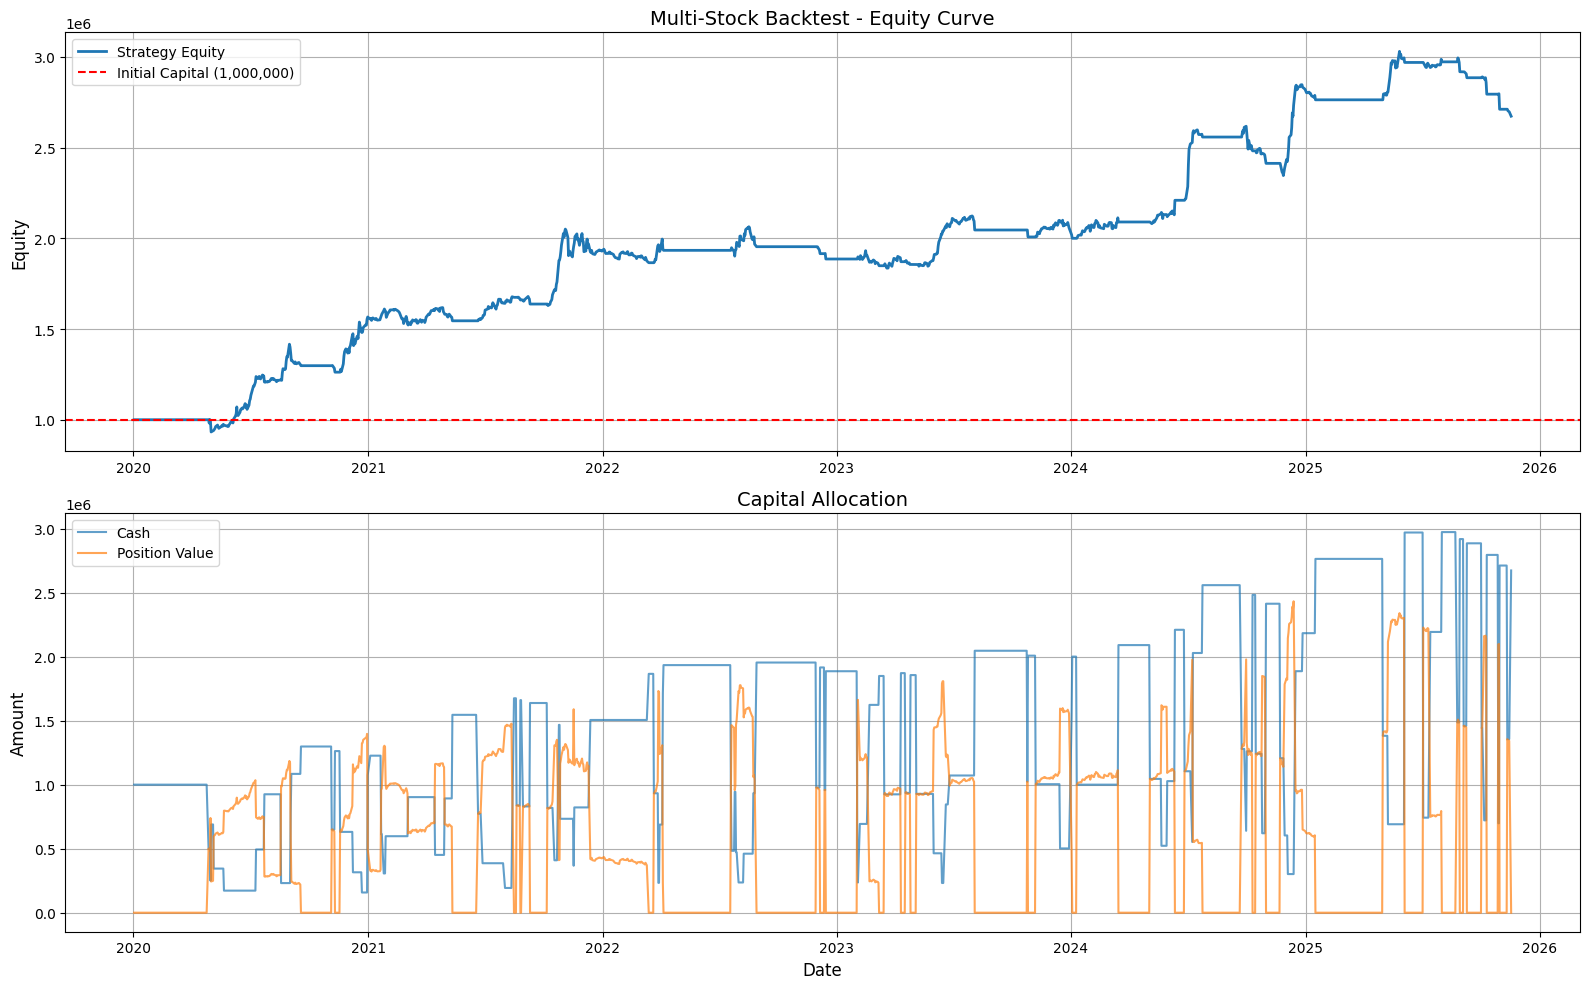


=== 績效指標 ===
總報酬率: 2.6728
年化報酬率: 0.2477
年化波動率: 0.1312
Sharpe: 1.3441
最大回撤: -0.1179
最終權益: 2672849.1976
最終現金: 2672849.1976

=== 交易紀錄（前 10 筆） ===
  symbol entry_date  exit_date  entry_price  exit_price       shares  \
0   TSLA 2020-04-27 2020-05-01    53.250000   46.754665  9389.671362   
1   TSLA 2020-05-21 2020-07-10    55.173332  102.976669  3122.028863   
2   TSLA 2020-08-18 2020-09-02   125.806000  149.123337  3675.837092   
3   TSLA 2020-11-18 2020-12-31   162.213333  235.223328  3890.462513   
4   TSLA 2021-01-25 2021-01-28   293.600006  278.476654  1044.164437   
5   TSLA 2021-08-02 2021-08-16   236.556671  228.723328   816.521683   
6   TSLA 2021-10-07 2021-10-25   264.536682  341.619995  3095.174669   
7   TSLA 2021-10-27 2021-12-13   345.953339  322.136658  2119.891630   
8   TSLA 2022-03-22 2022-04-05   331.326660  363.753326  2815.010966   
9   TSLA 2022-07-21 2022-07-26   271.706665  258.859985  1779.088164   

   holding_days  return_pct            pnl  \
0             4  

In [16]:
# 範例 1：使用固定比例倉位管理（預設）
print("=" * 60)
print("範例 1：固定比例倉位管理（預設）")
print("=" * 60)

buy_factors = [
    {"class": BreakoutBuyFactor, "xd": 60},
    {"class": BreakoutBuyFactor, "xd": 42},
]

sell_factors = [
    {"class": BreakdownSellFactor, "xd": 120},
    {"class": AtrStopSellFactor, "stop_loss_n": 0.5, "stop_win_n": 3.0}
]

# 使用預設的固定比例倉位管理（50%）
bt1 = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
)

results1, trades1, stats1 = bt1.run(show_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats1.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n=== 交易紀錄（前 10 筆） ===")
print(trades1.head(10))

print(f"\n總交易次數: {len(trades1)}")
print(f"各股票交易次數:")
print(trades1.groupby('symbol').size())


範例 2：基於風險的倉位管理


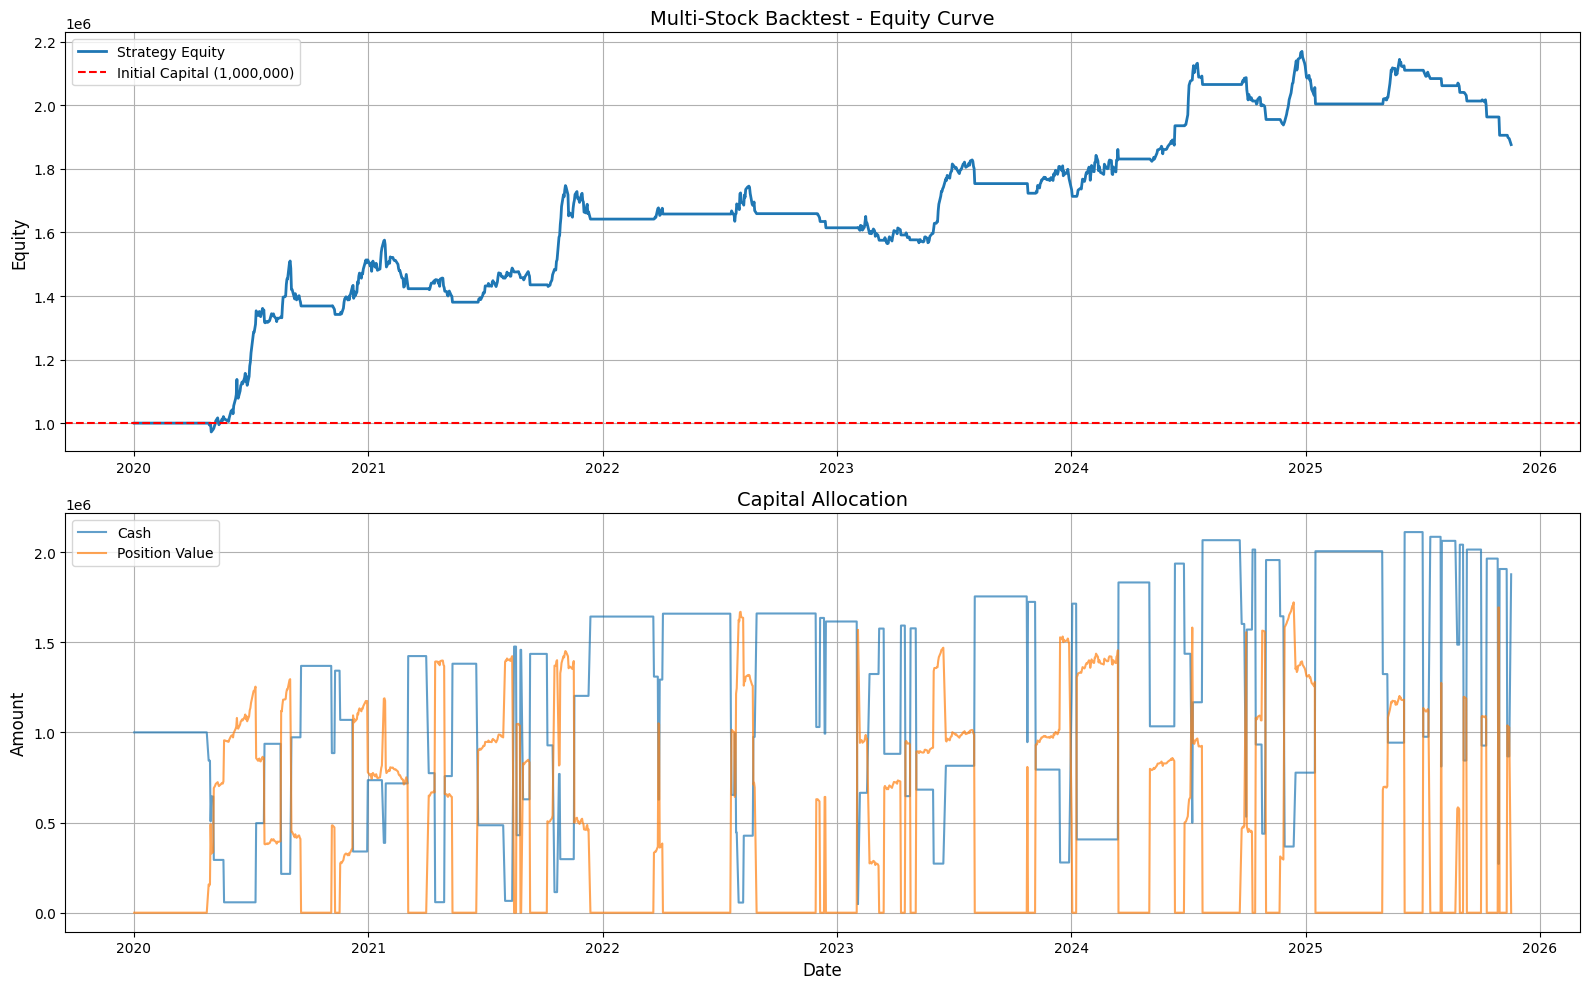


=== 績效指標 ===
總報酬率: 1.8765
年化報酬率: 0.1969
年化波動率: 0.1130
Sharpe: 1.0072
最大回撤: -0.1353
最終權益: 1876538.5066
最終現金: 1876538.5066

總交易次數: 57


In [17]:
# 範例 2：使用基於風險的倉位管理
print("=" * 60)
print("範例 2：基於風險的倉位管理")
print("=" * 60)

# 建立基於風險的倉位管理器
risk_position_manager = RiskBasedPositionManager(
    risk_per_trade=0.02,  # 每筆交易風險 2%
    atr_multiplier=2.0,   # ATR 倍數
    max_position_ratio=1.0  # 最大持倉比例 100%
)

bt2 = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
    position_manager=risk_position_manager  # 傳入自訂倉位管理器
)

results2, trades2, stats2 = bt2.run(show_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats2.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n總交易次數: {len(trades2)}")


範例 3：等權重倉位管理


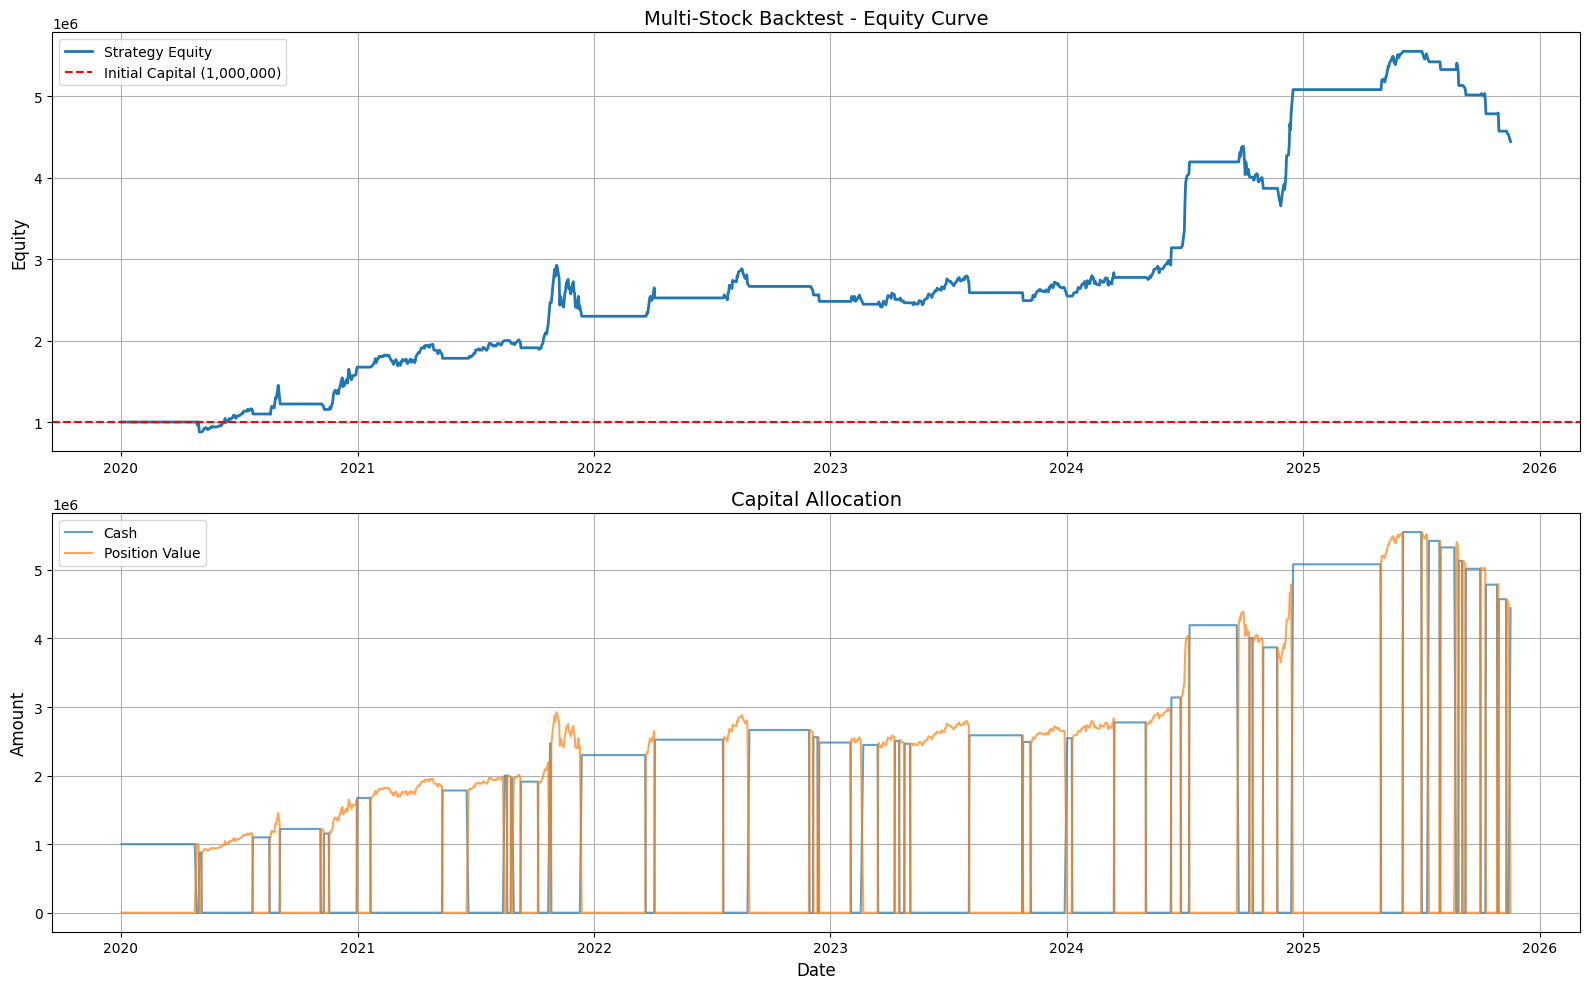


=== 績效指標 ===
總報酬率: 4.4433
年化報酬率: 0.3340
年化波動率: 0.2348
Sharpe: 1.2008
最大回撤: -0.2142
最終權益: 4443340.1100
最終現金: 4443340.1100

總交易次數: 37

各股票交易次數:
symbol
AAPL    13
MSFT    12
TSLA    12
dtype: int64


In [18]:
# 範例 3：使用等權重倉位管理
print("=" * 60)
print("範例 3：等權重倉位管理")
print("=" * 60)

# 建立等權重倉位管理器
equal_weight_manager = EqualWeightPositionManager(
    max_stocks=3  # 最多同時持有 3 檔股票
)

bt3 = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
    position_manager=equal_weight_manager
)

results3, trades3, stats3 = bt3.run(show_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats3.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n總交易次數: {len(trades3)}")
print(f"\n各股票交易次數:")
print(trades3.groupby('symbol').size())


範例：使用 Fixed Kelly 倉位管理
--- Fixed Kelly PM Initialized ---
Win Rate (p): 0.5500, Odds Ratio (r): 1.2000
Calculated Kelly Ratio (f): 0.0875
----------------------------------


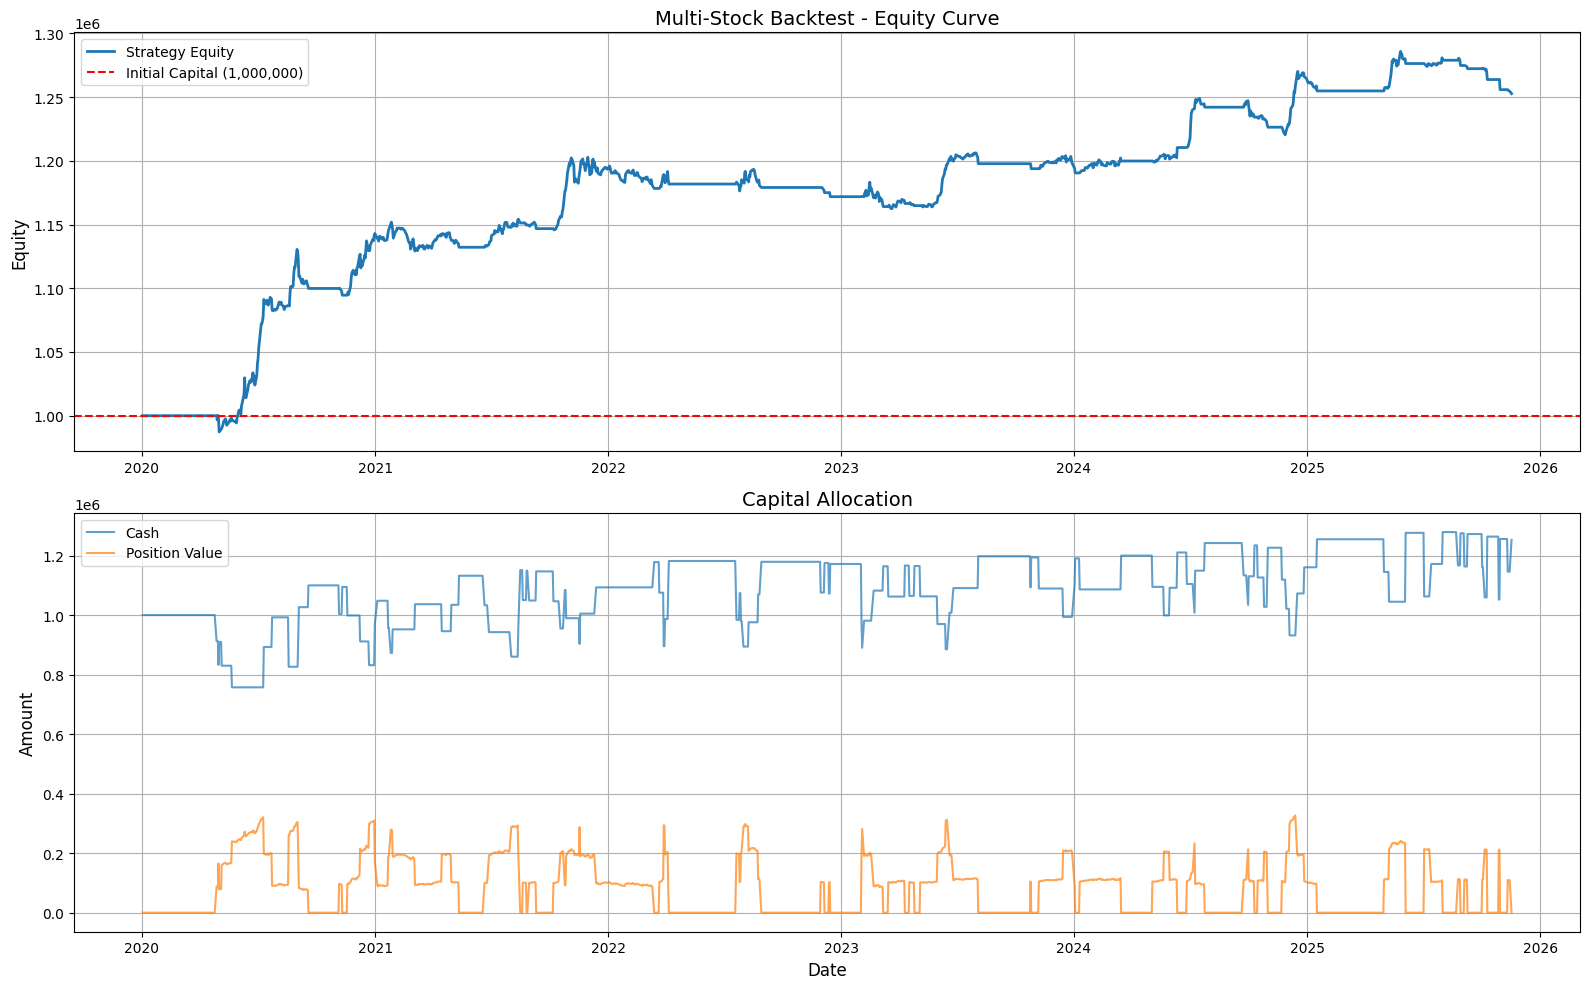


=== 績效指標 ===
總報酬率: 1.2527
年化報酬率: 0.1481
年化波動率: 0.0324
Sharpe: 1.2028
最大回撤: -0.0334
最終權益: 1252652.5768
最終現金: 1252652.5768

總交易次數: 65

各股票交易次數:
symbol
AAPL    22
MSFT    22
TSLA    21
dtype: int64


In [26]:
# 範例 4：Kelly公式的倉位管理

print("=" * 60)
print("範例：使用 Fixed Kelly 倉位管理")
print("=" * 60)

# 1. 建立 Fixed Kelly 倉位管理器
# 假設策略的預估參數為 p=0.55, r=1.2 (約產生 4.5% 的 Kelly 比例)
fixed_kelly_manager = FixedKellyPositionManager(
    win_rate=0.55, 
    odds_ratio=1.2, 
    full_kelly_ratio=0.5,  # 使用保守的半 Kelly 投入 (50%)
    max_position_ratio=1.0 # 最大倉位 100%
)

# FixedKellyPositionManager 在初始化時會打印計算出的 Kelly 比例

bt_kelly = MultiStockBacktester(
    stock_data=stock_data,
    buy_factors=buy_factors,
    sell_factors=sell_factors,
    initial_capital=1_000_000,
    position_manager=fixed_kelly_manager
)

# 執行回測並繪圖
# 假設 bt_kelly.run() 會返回 results, trades, stats
results_kelly, trades_kelly, stats_kelly = bt_kelly.run(show_plot=True)

print("\n=== 績效指標 ===")
for k, v in stats_kelly.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v:,.0f}")

print(f"\n總交易次數: {len(trades_kelly)}")
print(f"\n各股票交易次數:")
print(trades_kelly.groupby('symbol').size())

範例 4：比較不同倉位管理策略
--- Fixed Kelly PM Initialized ---
Win Rate (p): 0.5500, Odds Ratio (r): 1.2000
Calculated Kelly Ratio (f): 0.0875
----------------------------------

=== 倉位管理策略比較 ===
           策略名稱     總報酬率    年化報酬率   Sharpe      最大回撤  交易次數         最終權益
fix ratio (50%) 2.672849 0.247665 1.344143 -0.117932    65 2.672849e+06
fix ratio (30%) 1.930909 0.200686 1.292756 -0.081050    65 1.930909e+06
     risk based 1.876539 0.196868 1.007204 -0.135252    57 1.876539e+06
   equal weight 4.443340 0.334009 1.200816 -0.214243    37 4.443340e+06
    Fixed Kelly 1.252653 0.148121 1.202801 -0.033412    65 1.252653e+06


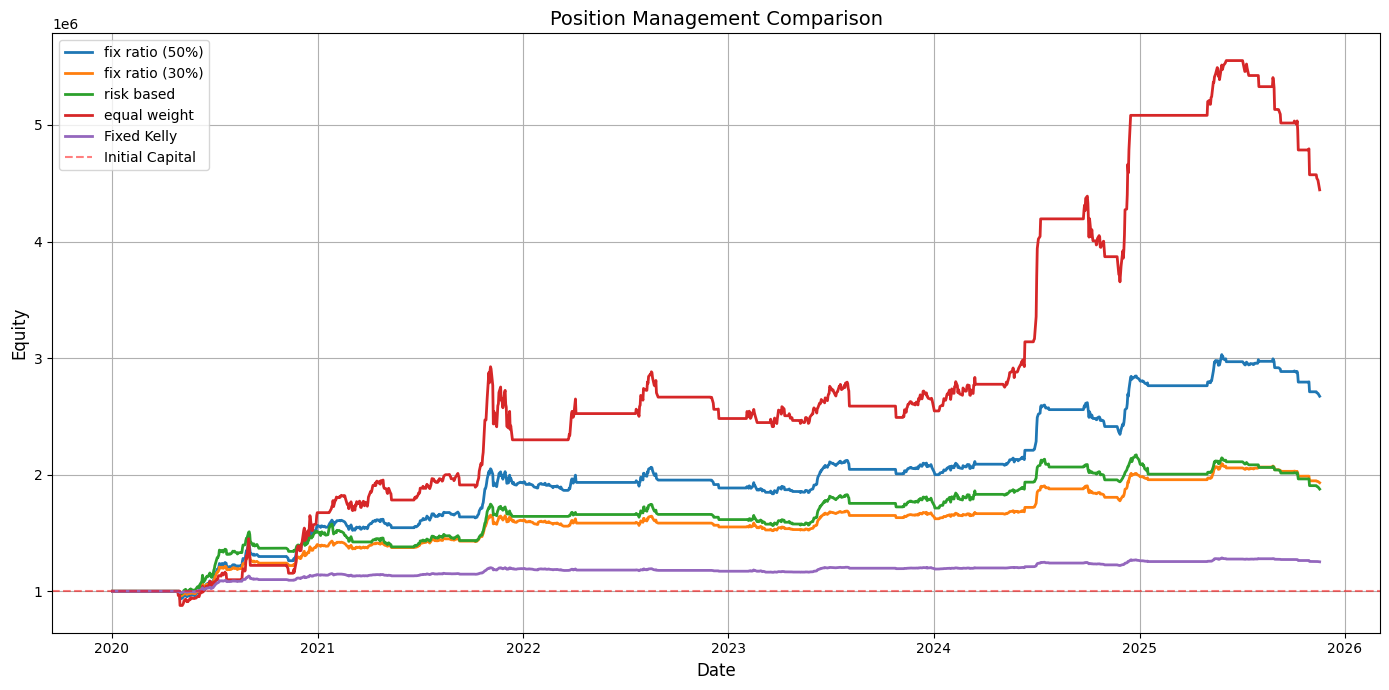

In [27]:
# 範例 5：比較不同倉位管理策略
print("=" * 60)
print("範例 4：比較不同倉位管理策略")
print("=" * 60)

# 定義不同的倉位管理策略
position_managers = {
    "fix ratio (50%)": FixedRatioPositionManager(position_ratio=0.5),
    "fix ratio (30%)": FixedRatioPositionManager(position_ratio=0.3),
    "risk based": RiskBasedPositionManager(risk_per_trade=0.02, atr_multiplier=2.0),
    "equal weight": EqualWeightPositionManager(max_stocks=3),
    "Fixed Kelly": FixedKellyPositionManager(win_rate=0.55, odds_ratio=1.2, full_kelly_ratio=0.5, max_position_ratio=1.0)
}

comparison_results = []

for name, pm in position_managers.items():
    bt = MultiStockBacktester(
        stock_data=stock_data,
        buy_factors=buy_factors,
        sell_factors=sell_factors,
        initial_capital=1_000_000,
        position_manager=pm
    )
    
    results, trades, stats = bt.run(show_plot=False)
    
    comparison_results.append({
        "策略名稱": name,
        "總報酬率": stats["總報酬率"],
        "年化報酬率": stats["年化報酬率"],
        "Sharpe": stats["Sharpe"],
        "最大回撤": stats["最大回撤"],
        "交易次數": len(trades),
        "最終權益": stats["最終權益"],
    })

comparison_df = pd.DataFrame(comparison_results)
print("\n=== 倉位管理策略比較 ===")
print(comparison_df.to_string(index=False))

# 繪製權益曲線比較
fig, ax = plt.subplots(figsize=(14, 7))

for name, pm in position_managers.items():
    bt = MultiStockBacktester(
        stock_data=stock_data,
        buy_factors=buy_factors,
        sell_factors=sell_factors,
        initial_capital=1_000_000,
        position_manager=pm
    )
    results, trades, stats = bt.run(show_plot=False)
    ax.plot(results['equity_curve'].index, 
            results['equity_curve'].values, 
            label=name, linewidth=2)

ax.axhline(y=1_000_000, color='r', linestyle='--', alpha=0.5, label='Initial Capital')
ax.set_title('Position Management Comparison', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Equity', fontsize=12)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
